<a href="https://colab.research.google.com/github/jyotidabass/Canny-edge-detection/blob/main/canny_edge_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!git clone https://github.com/cynicphoenix/Canny-Edge-Detector.git

fatal: destination path 'Canny-Edge-Detector' already exists and is not an empty directory.


In [27]:
#Implementation of Canny Edge Detector

#Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import ndimage

In [28]:
#This cell contains all the used functions for Phase I 

#Define RGB2gray function
def rgb2gray(img) :
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])


#Detemine gradient function for Fx and Fy using sobel filter(normlized)
def gradient_x(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
    return grad_img/np.max(grad_img)

def gradient_y(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))
    return grad_img/np.max(grad_img)


#Define gradient magnitude function
def gradient_mag(fx, fy) :
    grad_mag = np.hypot(fx, fy)
    return grad_mag/np.max(grad_mag)

In [29]:
#This cell contains all functions used in Phase 2

#2.a : Find closest direction D*
def closest_dir_function(grad_dir) :
    closest_dir_arr = np.zeros(grad_dir.shape)
    for i in range(1, int(grad_dir.shape[0] - 1)) :
        for j in range(1, int(grad_dir.shape[1] - 1)) :
            
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)) :
                closest_dir_arr[i, j] = 0
                
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)) :
                closest_dir_arr[i, j] = 45
                
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)) : 
                closest_dir_arr[i, j] = 90
                
            else:
                closest_dir_arr[i, j] = 135
                
    return closest_dir_arr


#2.b : Convert to thinned edge
def non_maximal_suppressor(grad_mag, closest_dir) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(closest_dir[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else :
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output/np.max(thinned_output)  

In [30]:
#This cell contains all the used functionsfor Phase III

#Function to include weak pixels that are connected to chain of strong pixels 
def DFS(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                
                    
#Hysteresis Thresholding
def hysteresis_thresholding(img) :
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)
    
    #Assign values to pixels
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            #Strong pixels
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            #Weak pixels
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            #Intermediate pixels
            else :
                temp_img[i, j] = 1
    
    #Include weak pixels that are connected to chain of strong pixels 
    total_strong = np.sum(temp_img == 2)
    while(1) :
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    #Remove weak pixels
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    

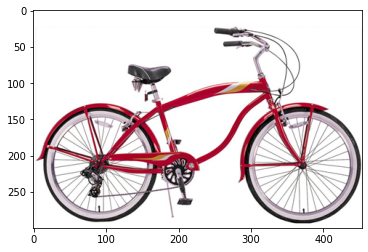

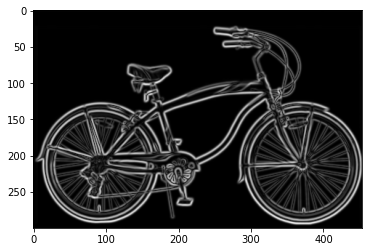

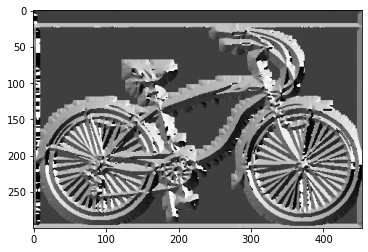

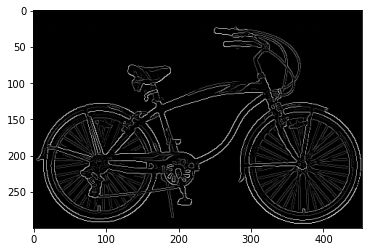

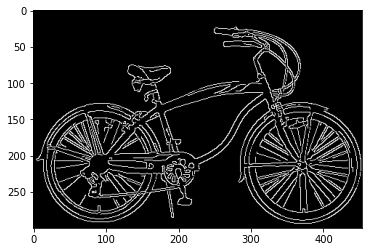

In [31]:
#Canny Edge Detector Implementation and test

input_path = "/content/Canny-Edge-Detector/data"
#output_path = "/content/Canny-Edge-Detector/canny_output"
img_name = ["/content/Canny-Edge-Detector/data/bicycle.bmp"]

#Load the input images
for img in img_name :
    input_img = imageio.imread(img)
    plt.imshow(input_img)
    plt.show()
    
    #Convert the image to grayscale
    gray_input_img = rgb2gray(input_img)
    
    #Apply gaussian blurring
    blur_img = ndimage.gaussian_filter(gray_input_img, sigma = 1.0)
    
    #Find gradient Fx
    x_grad = gradient_x(blur_img)
    
    #Find gradient Fy
    y_grad = gradient_y(blur_img)

    #Compute edge strength
    grad_mag = gradient_mag(x_grad, y_grad)
    plt.imshow(grad_mag, cmap = plt.get_cmap('gray'))
    plt.show()
    #imageio.imwrite(output_path + img.split('.')[0] + "/img1_grad_mag.jpg", grad_mag, cmap = 'gray')
    
    #Compute direction of gradient
    grad_dir = np.degrees(np.arctan2(y_grad, x_grad))
    plt.imshow(grad_dir, cmap = plt.get_cmap('gray'))
    plt.show()
    #imageio.imwrite(output_path + img.split('.')[0] + "/img2_grad_dir.jpg", grad_dir, cmap = 'gray')
    
    
    #Phase 2 : Non maximal suppression
    closest_dir = closest_dir_function(grad_dir)
    thinned_output = non_maximal_suppressor(grad_mag, closest_dir)
    plt.imshow(thinned_output, cmap = plt.get_cmap('gray'))
    plt.show()
    #imageio.imwrite(output_path + img.split('.')[0] + "/img3_thinned.jpg", thinned_output, cmap = 'gray')
    
   

    #Phase 3 : Hysteresis Thresholding
    output_img = hysteresis_thresholding(thinned_output)
    plt.imshow(output_img, cmap = plt.get_cmap('gray'))
    plt.show()
    #imageio.imwrite(output_path + img.split('.')[0] + "/img4_final_output.jpg", output_img, cmap = 'gray')
    